🔧 **Setup Required**: Before running this notebook, please follow the [setup instructions](../README.md#setup-instructions) to configure your environment and API keys.

# LangGraph Multi-Agent Yelp Navigator

An educational example of building a multi-agent system using LangGraph to create an intelligent Yelp business search assistant.

## What You'll Learn

- How to orchestrate multiple specialized agents working together
- How to implement conditional routing based on user needs
- How to integrate external tools and APIs into LangGraph workflows
- How to add quality control through a supervisor pattern

## Architecture

The system has **6 specialized agents**:

1. **Clarification Agent** - Extracts query, location, and detail level from user input
2. **Search Agent** - Finds businesses matching the criteria
3. **Details Agent** - Fetches additional info (websites, descriptions) - *optional*
4. **Sentiment Agent** - Analyzes customer reviews - *optional*
5. **Summary Agent** - Creates a user-friendly response
6. **Supervisor Agent** - Reviews quality and can request revisions

**Workflow:** User Query → Clarification → Search → [Details] → [Sentiment] → Summary → Approval → End

Agents in brackets are only called when the user needs that level of detail.

## Prerequisites

**Start Hayhooks server:**
```bash
cd yelp-navigator
uv run sh build_all_pipelines.sh && sh start_hayhooks.sh
```

In [1]:
# =============================================================================
# STEP 1: Imports and Configuration
# =============================================================================

import os
import json
import requests
from typing import Annotated, TypedDict, List, Dict, Any
from operator import add

# LangGraph for building agent workflows
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain.agents import create_agent
from dotenv import load_dotenv
from pathlib import Path

# Load .env from the root of ch8 directory
root_dir = Path(__file__).parent.parent if "__file__" in globals() else Path.cwd().parent
load_dotenv(root_dir / ".env")

# Import custom agent logic from helper modules
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'langgraph-helpers'))
from langgraph_helpers.agents import clarification_agent, supervisor_approval_agent
from langgraph_helpers.nodes import search_agent_node, details_agent_node, sentiment_agent_node, summary_agent_node
from langgraph_helpers.tools import search_businesses, get_business_details, analyze_reviews_sentiment, set_base_url

# Configure endpoints
BASE_URL = "http://localhost:1416"  # Hayhooks server
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

set_base_url(BASE_URL)

if not OPENAI_API_KEY:
    print("⚠️  Warning: OPENAI_API_KEY not set. Please add it to your .env file.")
else:
    print("✅ OpenAI API key configured")
    print(f"✅ Hayhooks server: {BASE_URL}")

✅ OpenAI API key configured
✅ Hayhooks server: http://localhost:1416


In [2]:
# =============================================================================
# STEP 2: Define Agent State
# =============================================================================
# AgentState is the "shared memory" for all agents in the workflow.
# Each agent reads from and writes to this state as the workflow progresses.

class AgentState(TypedDict):
    """State shared across all agents in the workflow."""
    
    # Conversation tracking
    messages: Annotated[List[BaseMessage], add]  # Full conversation history
    
    # User intent (set by Clarification Agent)
    user_query: str              # Original user question
    clarified_query: str         # What they're looking for (e.g., "Mexican restaurants")
    clarified_location: str      # Where to search (e.g., "Austin, Texas")
    detail_level: str            # "general", "detailed", or "reviews"
    
    # Workflow control
    clarification_complete: bool  # True when ready to proceed to search
    next_agent: str              # Which agent to call next (enables conditional routing)
    
    # Agent results
    agent_outputs: Dict[str, Any]  # Results from each agent (search, details, sentiment)
    
    # Final output
    final_summary: str  # User-friendly response
    
    # Quality control (for Supervisor Agent)
    approval_attempts: int      # How many times supervisor has reviewed (max 2)
    needs_revision: bool        # True if summary needs improvement
    revision_feedback: str      # What to improve

## Step 3: Initialize Language Model

In [3]:
# Initialize the LLM that will power our agents
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
# =============================================================================
# STEP 4: Create Agent Wrapper Functions
# =============================================================================
# Wrappers pass the LLM to agents that need it for reasoning

def clarification_agent_wrapper(state: AgentState) -> AgentState:
    """Extracts query, location, and detail level from user input."""
    return clarification_agent(state, llm)

def supervisor_approval_agent_wrapper(state: AgentState) -> AgentState:
    """Reviews summary quality and decides if revision is needed."""
    return supervisor_approval_agent(state, llm)

In [5]:
# Wrappers pass tools to agents that interact with external pipelines

def search_agent_wrapper(state: AgentState) -> AgentState:
    """Searches for businesses using the Hayhooks search pipeline."""
    return search_agent_node(state, search_businesses)

def details_agent_wrapper(state: AgentState) -> AgentState:
    """Fetches business details (website, description) via Hayhooks."""
    return details_agent_node(state, get_business_details)

def sentiment_agent_wrapper(state: AgentState) -> AgentState:
    """Analyzes review sentiment via Hayhooks sentiment pipeline."""
    return sentiment_agent_node(state, analyze_reviews_sentiment)

def summary_agent_wrapper(state: AgentState) -> AgentState:
    """Synthesizes all information into a user-friendly response."""
    return summary_agent_node(state, llm)

In [6]:
# =============================================================================
# STEP 5: Define Routing Logic and Build the Workflow
# =============================================================================

def route_after_clarification(state: AgentState) -> str:
    """Route to search if clarification is complete, otherwise loop back."""
    return "search" if state.get("clarification_complete", False) else "clarification"

def route_from_agents(state: AgentState) -> str:
    """Dynamic routing based on next_agent value set by each agent."""
    next_agent = state.get("next_agent", "end")
    return END if next_agent == "end" else next_agent

# Build the workflow graph
workflow = StateGraph(AgentState)

# Add all agent nodes
workflow.add_node("clarification", clarification_agent_wrapper)
workflow.add_node("search", search_agent_wrapper)
workflow.add_node("details", details_agent_wrapper)
workflow.add_node("sentiment", sentiment_agent_wrapper)
workflow.add_node("summary", summary_agent_wrapper)
workflow.add_node("supervisor_approval", supervisor_approval_agent_wrapper)

# Define workflow edges (how agents connect)
workflow.add_edge(START, "clarification")
workflow.add_conditional_edges("clarification", route_after_clarification, {"clarification": "clarification", "search": "search"})
workflow.add_conditional_edges("search", route_from_agents, {"details": "details", "sentiment": "sentiment", "summary": "summary", END: END})
workflow.add_conditional_edges("details", route_from_agents, {"sentiment": "sentiment", "summary": "summary", END: END})
workflow.add_conditional_edges("sentiment", route_from_agents, {"summary": "summary", END: END})
workflow.add_conditional_edges("summary", route_from_agents, {"supervisor_approval": "supervisor_approval", END: END})
workflow.add_conditional_edges("supervisor_approval", route_from_agents, {"search": "search", "details": "details", "sentiment": "sentiment", "summary": "summary", END: END})

# Compile the workflow
app = workflow.compile()
print("✅ Multi-agent workflow compiled and ready!")

✅ Multi-agent workflow compiled and ready!


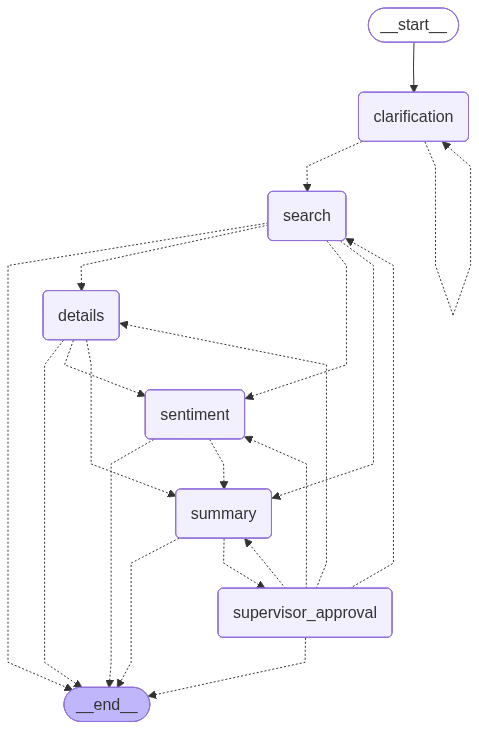

In [7]:
# Visualize the workflow graph
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(app.get_graph())

## Examples: Running the Multi-Agent System

Below are three examples showing different detail levels:
- **General**: Basic business info only
- **Detailed**: Includes websites and descriptions
- **Reviews**: Full analysis with sentiment

### Example 1: General Search

In [8]:
# Example 1: General search - basic business information only
result = app.invoke({
    "user_query": "Find me pizza places in Chicago",
    "messages": [],
    "agent_outputs": {},
    "clarification_complete": False
})

print("\n" + "="*80)
print("EXAMPLE 1: GENERAL SEARCH")
print("="*80 + "\n")

for msg in result["messages"]:
    role = "User" if isinstance(msg, HumanMessage) else "Assistant"
    print(f"\n{role}:")
    print(msg.content)
    print("-" * 80)


EXAMPLE 1: GENERAL SEARCH


Assistant:
CLARIFIED:
QUERY: pizza places
LOCATION: Chicago
DETAIL_LEVEL: general
--------------------------------------------------------------------------------

Assistant:
Found 10 businesses:
1. Giordano's - 3.8 stars (4226 reviews)
2. Chicago Pizza And Oven Grinder Company - 4.1 stars (3241 reviews)
3. Pequod's Pizza - 3.9 stars (8787 reviews)
4. PIZZ'AMICI - 4.1 stars (86 reviews)
5. Lou Malnati's Pizzeria - 4.1 stars (7772 reviews)
6. Michael's Original Pizzeria & Tavern - 4.3 stars (944 reviews)
7. Milly’s Pizza In The Pan - 4.6 stars (191 reviews)
8. Coalfire Pizza - 4.3 stars (1251 reviews)
9. Chicago's Pizza - 3.3 stars (302 reviews)
10. Chicago's Pizza - 3.6 stars (444 reviews)
--------------------------------------------------------------------------------

Assistant:
SUMMARY:

If you're on the hunt for some delicious pizza in Chicago, you're in luck! The city is home to a variety of fantastic pizza places that cater to all tastes. For a classi

## Key Features Summary

- **Clarification Agent**: Extracts query, location, detail level (with fallback defaults after 2 attempts)
- **Conditional Routing**: Details and sentiment agents only run when user needs that information
- **Tool Integration**: Each agent calls specific Haystack pipelines via Hayhooks
- **Quality Control**: Supervisor reviews summaries (max 2 approval attempts to prevent loops)
- **Flexible Detail Levels**: Supports `general`, `detailed`, or `reviews` workflows

## Next Steps

- Explore the `langgraph_helpers/` modules to see agent implementation details
- Try modifying the routing logic to add new agents or change workflow paths
- Experiment with different detail levels and observe how the workflow adapts